In [6]:
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import os,sys
from PIL import Image
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import random

In [7]:
def load_image(infilename):
    data = mpimg.imread(infilename)
    return data

def img_float_to_uint8(img):
    rimg = img - np.min(img)
    rimg = (rimg / np.max(rimg) * 255).round().astype(np.uint8)
    return rimg

# Concatenate an image and its groundtruth
def concatenate_images(img, gt_img):
    nChannels = len(gt_img.shape)
    w = gt_img.shape[0]
    h = gt_img.shape[1]
    if nChannels == 3:
        cimg = np.concatenate((img, gt_img), axis=1)
    else:
        gt_img_3c = np.zeros((w, h, 3), dtype=np.uint8)
        gt_img8 = img_float_to_uint8(gt_img)          
        gt_img_3c[:,:,0] = gt_img8
        gt_img_3c[:,:,1] = gt_img8
        gt_img_3c[:,:,2] = gt_img8
        img8 = img_float_to_uint8(img)
        cimg = np.concatenate((img8, gt_img_3c), axis=1)
    return cimg

In [8]:
# Loaded a set of images
root_dir = "training/"

image_dir = root_dir + "images/"
files = os.listdir(image_dir)
n = min(20, len(files)) # Load maximum 20 images
print("Loading " + str(n) + " images")
imgs = [load_image(image_dir + files[i]) for i in range(n)]
print(files[0])

gt_dir = root_dir + "groundtruth/"
print("Loading " + str(n) + " images")
gt_imgs = [load_image(gt_dir + files[i]) for i in range(n)]
print(files[0])

n = 10 # Only use 10 images for training

Loading 20 images
satImage_052.png
Loading 20 images
satImage_052.png


In [321]:
train_input = torch.tensor(imgs).permute(0,3,1,2)
train_target = torch.tensor(gt_imgs)
train_target[train_target < 0.5] = 0
train_target[train_target > 0.5] = 1
train_target = train_target.long()

In [149]:
training_target.shape

torch.Size([20, 400, 400])

In [150]:
training_input.shape

torch.Size([20, 3, 400, 400])

In [140]:
def concatenate(x1,x2):
    diffX = x1.shape[2] - x2.shape[2]
    diffY = x1.shape[3] - x2.shape[3]
    x1 = x1[:,:, diffX // 2 : x1.shape[2] - diffX // 2 - diffX % 2,:]
    x1 = x1[:,:,:, diffY // 2 : x1.shape[3] - diffY // 2 - diffY % 2]
    
    return torch.cat([x1,x2], axis = 1)

In [332]:
def doubleConv(in_channel, out_channel):
    return nn.Sequential(
        nn.Conv2d(in_channel, out_channel, kernel_size = 3),
        nn.BatchNorm2d(out_channel),
        nn.ReLU(True),
        nn.Conv2d(out_channel, out_channel, kernel_size = 3),
        nn.BatchNorm2d(out_channel),
        nn.ReLU(True)
    )

class Unet(nn.Module):
    def __init__(self, output_channel):
        super(Unet, self).__init__()
        #_LEFT
        self.conv1 = doubleConv(3,64)
        self.conv2 = doubleConv(64,128)
        self.conv3 = doubleConv(128,256)
        self.conv4 = doubleConv(256,512)
        self.conv5 = doubleConv(512,1024)
        
        self.maxPool = nn.MaxPool2d(kernel_size = 2)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
        #RIGHT  
        self.conv6 = doubleConv(1024+512,512)
        self.conv7 = doubleConv(512+256,256)
        self.conv8 = doubleConv(256+128,128)
        self.conv9 = doubleConv(128+64,64)
        
        #layer to match input size
        self.outConv1 = nn.Conv2d(64,64, kernel_size= 13)
        self.outConv = nn.Conv2d(64, output_channel, kernel_size = 1)
        
    def forward(self,x):
        #DOWN DIRECTION
        x1 = self.conv1(x)
        
        x = self.maxPool(x1)
        x2 = self.conv2(x)
        
        x = self.maxPool(x2)
        x3 = self.conv3(x)
        
        x = self.maxPool(x3)
        x4 = self.conv4(x)
        
        x = self.maxPool(x4)
        x = self.conv5(x)
        
        #UP DIRECTION
        x = self.up(x)
        x = self.conv6(concatenate(x4, x))
        
        x = self.up(x)
        x = self.conv7(concatenate(x3, x))
        
        x = self.up(x)
        x = self.conv8(concatenate(x2, x))
        
        x = self.up(x)
        x = self.conv9(concatenate(x1, x))
        
        x = self.outConv1(x)
        x = self.outConv(x)
        x = self.up(x)
        
        
        return x

In [333]:
def visualize(model,idx):
    prediction = model(training_input[idx:idx + 1])
    prediction = torch.max(prediction, dim=1).indices
    cimg = concatenate_images(imgs[idx],prediction[0].detach().numpy())
    cimg = concatenate_images(cimg,train_target[idx].numpy())
    fig1 = plt.figure(figsize=(10, 10)) # create a figure with the default size 
    plt.imshow(cimg, cmap='Greys_r')

In [334]:
def trainModel(model, criterion, optimizer, epoch, train_input, train_target, batch_size):
    print("TRAINING")
    print("EPOCH : TOT_LOSS")
    for e in range(epoch):
        for input, target in zip(train_input.split( batch_size), train_target.split( batch_size)):
            optimizer.zero_grad()
            prediction = model(input)
            loss = criterion(prediction, target)
            nn.utils.clip_grad_value_(model.parameters(), 1)
            loss.backward()
            optimizer.step()
        print("{:5} {:>10.4f}".format(e, loss.item()))

In [335]:
model = Unet(output_channel=2)

In [336]:
lr = 10e-4
nb_epoch = 5
batch_size = 1

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr)

trainModel(model,criterion, optimizer, nb_epoch, train_input[:1], train_target[:1], batch_size)

TRAINING
EPOCH : TOT_LOSS
    0     0.7267
    1     4.1102
    2     3.6584
    3     1.9707
    4     0.8668


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


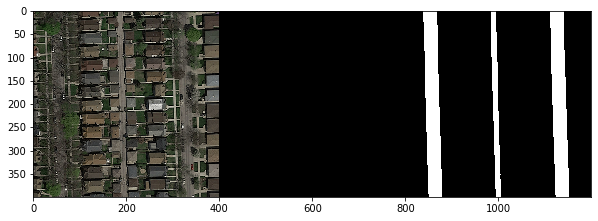

In [338]:
visualize(model,0)

In [337]:
#for debug (to see the value output, maybe visualize is buggy)

In [339]:
out = model(training_input[:1])

In [340]:
out[0][0][0]

tensor([ 1.8595,  1.9303,  2.0010,  2.0886,  2.1764,  2.3269,  2.4781,  2.5799,
         2.6810,  2.8074,  2.9343,  3.0496,  3.1645,  3.2855,  3.4067,  3.5571,
         3.7086,  3.8829,  4.0583,  4.2173,  4.3756,  4.5235,  4.6709,  4.7783,
         4.8833,  4.9766,  5.0691,  5.1237,  5.1757,  5.1571,  5.1331,  5.0184,
         4.8963,  4.7248,  4.5489,  4.3730,  4.1971,  4.0435,  3.8922,  3.7197,
         3.5449,  3.3696,  3.1943,  3.0131,  2.8313,  2.6332,  2.4331,  2.2118,
         1.9877,  1.7814,  1.5776,  1.3924,  1.2100,  1.0578,  0.9101,  0.7936,
         0.6819,  0.5857,  0.4921,  0.4323,  0.3782,  0.3362,  0.2964,  0.2600,
         0.2243,  0.2032,  0.1850,  0.1818,  0.1815,  0.1909,  0.2023,  0.2237,
         0.2472,  0.2874,  0.3312,  0.4257,  0.5318,  0.7050,  0.8940,  1.1973,
         1.5285,  1.9984,  2.5031,  3.1746,  3.8894,  4.7595,  5.6711,  6.6895,
         7.7373,  8.8393,  9.9566, 11.1333, 12.3275, 13.5580, 14.7994, 16.0251,
        17.2459, 18.4699, 19.6949, 20.84

In [341]:
out[0][1][0]

tensor([ -1.6016,  -1.6790,  -1.7565,  -1.8679,  -1.9796,  -2.1118,  -2.2443,
         -2.3792,  -2.5141,  -2.6627,  -2.8116,  -2.9151,  -3.0173,  -3.1252,
         -3.2333,  -3.4050,  -3.5790,  -3.7442,  -3.9090,  -4.0757,  -4.2424,
         -4.4177,  -4.5934,  -4.7367,  -4.8782,  -4.9575,  -5.0328,  -5.0019,
         -4.9636,  -4.9103,  -4.8559,  -4.7240,  -4.5857,  -4.4303,  -4.2734,
         -4.1273,  -3.9823,  -3.8438,  -3.7059,  -3.5666,  -3.4272,  -3.2446,
         -3.0572,  -2.8563,  -2.6539,  -2.4399,  -2.2245,  -1.9989,  -1.7721,
         -1.5694,  -1.3699,  -1.2180,  -1.0729,  -0.9453,  -0.8204,  -0.6992,
         -0.5786,  -0.4835,  -0.3927,  -0.3152,  -0.2400,  -0.1919,  -0.1487,
         -0.1196,  -0.0932,  -0.0689,  -0.0450,  -0.0366,  -0.0313,  -0.0363,
         -0.0435,  -0.0558,  -0.0692,  -0.1095,  -0.1556,  -0.2520,  -0.3598,
         -0.5635,  -0.7897,  -1.1182,  -1.4717,  -1.9547,  -2.4702,  -3.1430,
         -3.8566,  -4.7051,  -5.5897,  -6.5781,  -7.5952,  -8.68

In [222]:
torch.max(out, dim=1).indices[0]

tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]])